## Pv4 heterozygous calls

My Drive/GitHub/gtg/Pf4_het_calls_230318.ipynb

This code examines the frequency distribution of heterozgous genotype calls in the [Pv4 dataset](https://www.malariagen.net/sites/default/files/File8_Pf_6_README_20191010_0.txt).  It uses downloaded Zarr data and sample metadata that are stored on Google Drive\My Drive\Colab Data\Pv4\. 

* extract lists of samples (n = 1,895) and variant properties (n = 4,571,056) as arrays

* select variants that are high-quality biallelic coding SNPs (n = 429,612)

* extract allele depth for high-quality SNPs from Zarr into `allele_depth_1.npy`.  We do this in chunks of 10,000 variants at a time to avoid memory problems

* extract sample metadata from samples.txt into a dataframe

* read info about sample QC into an array

* extract allele depth for high-quality SNPs and high-quality samples (n = 1,072) into `allele_depth_2.npy` 

* calculate within-host heterozygosity for each SNP in each sample and save to `wiho_het.npy`

* calculate mean within-host heterozygosity for each SNP across all samples and save to a list called wiho_het_per_snp

* using wiho_het_per_snp, create `snp_filter` to filter out potential hyperhet SNPs

* create `sample_filter` to select samples from a particular geographical region

* calculate $\pi_W$ for each sample, using mean within-host heterozygosity per sample, and allowing for the number of SNPs ascertained and the size of coding regions

* plot a histogram of nucleotide diversity per sample

* view the histogram for different filter cutoffs for hyperhet SNPs and for different regions e.g. West Africa vs Southeast Asia

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

data_path = "/content/drive/My Drive/Colab Data/Pv4/"

In [1]:
!pip install zarr

import zarr
import numcodecs
import numpy as np
import pandas as pd
import json
import math
import time
import matplotlib.pyplot as plt
import statistics as stat

In [14]:
callset = zarr.open_group(data_path + 'Pv_4.zarr', mode = 'r')
# callset.tree()

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, name='calldata', nodes=(Node(disabled=Tru…

# Run

#### Extract lists of samples and variant properties as arrays
* 1,895 samples
* 4,571,056 variants

#### Select high-quality biallelic SNPs
* high quality means 'filter_pass == True' & 'vqslod > 3'
* 429,612 variants meet criteria
* `select` is a mask for an array of 4,571,056 variants

In [3]:
samples = callset['samples'][:]

filter_pass = callset['variants/FILTER_PASS'][:]
vqslod = callset['variants/VQSLOD'][:]
snp = callset['variants/is_snp'][:]
coding = callset['variants/CDS'][:]
numalt = callset['variants/numalt'][:]
effect = callset['variants/SNPEFF_EFFECT'][:]

# select biallelic synonymous coding SNPs and create a mask
select = (filter_pass == True) & (snp == True) & (numalt == 1) & (vqslod > 3)

# & (coding == True) & (effect == 'SYNONYMOUS_CODING') 

selected_snps = np.count_nonzero(select == True)

total_variants = len(snp)
total_samples = len(samples)

print('There are {0:d} variants and {1:d} selected SNPs in {2:d} samples.'.
      format(total_variants, selected_snps, total_samples))

There are 6051696 variants and 502221 selected SNPs in 7113 samples.


#### Save allele depths for selected SNPs in `allele_depth_1.npy`
* Use the `select` mask created above to pull out selected SNPs
* Copy allele depths for selected SNPs from 'calldata/AD' into `allele_depth_1`
  * calldata/AD allows for multiallelic loci by containing allele depth for up to 7 variant alleles
  * Since we focus on biallelic SNPs we include only the first two alleles from calldata/AD
* This file is 3.2GB

In [ ]:
# We extract allele depth data for selected SNPs into a numpy array.
# We do this in chunks of 10000 variants at a time to avoid memory problems.
# This step can be omitted by retrieving saved data in the next section.

ad = callset['calldata/AD']

allele_depth_1 = 9 * np.ones((selected_snps, total_samples, 2), dtype=np.int16)

selected_snp_id = 0

chunk_size = 10000

for i in range(int(total_variants / chunk_size)):
    
    start_time = time.time()
    
    chunk = ad[(i * chunk_size) : ((i + 1) * chunk_size), :, :2]
    
    chunk_snps = 0

    for j in range(chunk_size):
        
        variant_id = i * chunk_size + j
    
        if select[variant_id] == True:
            
            allele_depth_1[selected_snp_id, :, :] = chunk[j, :, :]
            
            selected_snp_id += 1
            
            chunk_snps += 1
               
    chunk_time = time.time() - start_time
        
    print('chunk {0:d} had {1:d} SNPs and took {2:.2f} seconds'.
          format(i, chunk_snps, chunk_time))

start_time = time.time()

chunk = ad[(i * chunk_size) :, :, :]

chunk_snps = 0

for j in range(total_variants % chunk_size):
    
    if select[(i + 1) * chunk_size + j] == True:
            
        allele_depth_1[selected_snp_id, :, :] = chunk[j, :, :]
        
        selected_snp_id += 1
            
        chunk_snps += 1
               
    chunk_time = time.time() - start_time
        
print('chunk {0:d} had {1:d} SNPs and took {2:.1f} seconds'.
     format(i, chunk_snps, chunk_time))

total_snps = selected_snp_id

print('total of {0:d} selected snps'.format(total_snps))

np.save(data_path + '220318_allele_depth_1', allele_depth_1)

# Run

#### Select samples and list region of each selected sample
* 'Population' in Pv4_samples.txt gives: LAM=Latin America, AF=Africa, WAS=Western Asia, WSEA=Western SE Asia, ESEA=Eastern SE Asia, MSEA=Maritime SE Asia, OCE=Oceania, unassigned

In [10]:
df = pd.read_table(data_path + 'samples.txt')

select_sample = np.array(df['QC pass'])

selected_samples = np.count_nonzero(select_sample == True)

print('There are', str(selected_samples), 'selected samples that passed QC')

region = []

for i in range(total_samples):
    
    if select_sample[i] == True:
        
        region.append(df['Population'][i])
        
with open(data_path + "230318_region", "w") as fp:
    json.dump(region, fp)

There are 5970 selected samples that passed QC


#### Copy allele depth for QC pass samples from `allele_depth_1` into `allele_depth_2`
* 'QC pass' field in samples.txt gives True/False
* Save as .npy file (~11.7GB) so that this step only has to be run once

In [35]:
allele_depth_1 = np.load(data_path + '230318_allele_depth_1.npy')

allele_depth_2 = 9 * np.ones((selected_snps, selected_samples, 2), dtype=np.int16)

selected_sample_id = 0

for i in range(total_samples):
    
    if select_sample[i] == True:
        
        allele_depth_2[:, selected_sample_id, :] = allele_depth_1[:, i, :]
        
        selected_sample_id += 1
        
np.save(data_path + '230318_allele_depth_2', allele_depth_2)

There are 5970 selected samples that passed QC


#### Calculate within-host heterozygosity for each SNP and save as `wiho_het.npy`
* if ref_allele + alt_allele == 1 then write het = 0.
* this file is 3.6GB because dtype=float

In [ ]:
allele_depth_2 = np.load(data_path + '230318_allele_depth_2.npy') #, mmap_mode = 'r')

selected_samples = len(allele_depth_2[0, :, 0])

wiho_het = np.ones((selected_snps, selected_samples), dtype=float)

for i in range(selected_snps):
    for j in range(selected_samples):
        
        ref_allele = allele_depth_2[i, j, 0]
        alt_allele = allele_depth_2[i, j, 1]
        denominator = ref_allele + alt_allele
        if denominator != 0:
            allele_freq = alt_allele / denominator
            het = 2 * allele_freq * (1 - allele_freq)
        else:
            het = 0 # this is a hack
            
        wiho_het[i, j] = het

    if i % 100 == 0:
        print(i)
        
np.save(data_path + '230318_wiho_het.npy', wiho_het)

#### Calculate mean within-host heterozygosity for each SNP

In [7]:
wiho_het = np.load(data_path + '230318_wiho_het.npy', mmap_mode = 'r')

het_per_snp = []

for i in range(selected_snps):
    
    x = np.mean(wiho_het[i, :])
    
    het_per_snp.append(x)
    
with open(data_path + "230318_het_per_snp", "w") as filepath:
    json.dump(het_per_snp, filepath)        

# Run

#### Create `snp_filter` to filter out possible hyperhets
* Here we use het >= 0.02 as our criterion for exclusion 

In [19]:
with open(data_path + "230318_het_per_snp", "r") as fp:
    het_per_snp = json.load(fp)

snp_filter = []

for i in range(selected_snps):
    
    if het_per_snp[i] < 0.02:
        
        snp_filter.append(True)
    
    else:
        snp_filter.append(False)
        
filtered_snps = snp_filter.count(True)
        
print('This includes', str(filtered_snps), 'SNPs')

This includes 496459 SNPs


# Run

#### Create `sample_filter` to select a particular geographical region
* LAM=Latin America, AF=Africa, WAS=Western Asia, WSEA=Western SE Asia, ESEA=Eastern SE Asia, MSEA=Maritime SE Asia, OCE=Oceania, unassigned

In [20]:
with open(data_path + "230318_region", "r") as fp:
    region = json.load(fp)

sample_filter = []

for i in range(selected_samples):
    
    if region[i] != False:
        
        sample_filter.append(True)
        
    else:
        
        sample_filter.append(False)
        
filtered_samples = sample_filter.count(True)
    
print('This includes', str(filtered_samples), 'samples')

This includes 5970 samples


# Run

#### Calculate mean heterozygosity per sample after filtering samples and SNPs
* Creates a list of het values, one for each selected & filtered sample 
* This is the mean het for selected & filtered SNPs and not for all nucleotide positions

In [21]:
wiho_het = np.load(data_path + '230318_wiho_het.npy', mmap_mode = 'r')

het_per_sample = []

for i in range(selected_samples):
    
    if sample_filter[i] == True:

        het = []
    
        for j in range(selected_snps):
    
            if snp_filter[j] == True: 
            
                het.append(wiho_het[j, i])
    
        y = stat.mean(het)
    
        het_per_sample.append(y)
    
    if i % 1000 == 0:
        
        print(i)
        
with open(data_path + "230318_het_per_sample_ALL", "w") as filepath:
    json.dump(het_per_sample, filepath)

0
1000
2000
3000
4000
5000


#### Plot histogram of within-host nucleotide diversity

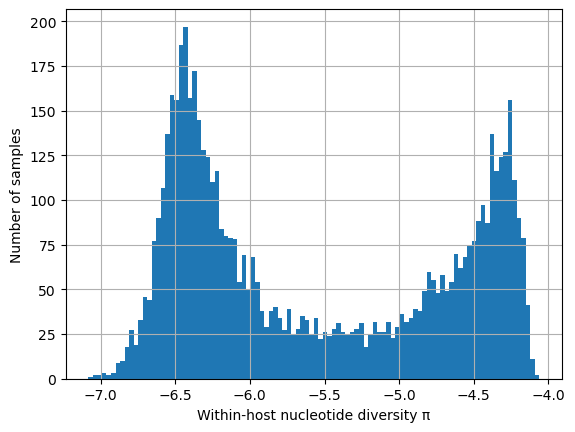

In [23]:
# All regions - only SNPs with maf < 0.01

with open(data_path + "230318_het_per_sample_ALL", "r") as filepath:
    het_per_sample = json.load(filepath)
    
selected_snps = 494829 # this is <0.01 maf, total is 502221
coding_positions = 12028350 # from Gardner et al 2002

convert_het_to_pi = selected_snps / coding_positions

het_per_sample_nonzero = [convert_het_to_pi * x for x in het_per_sample if x != 0]
log_het_per_sample = [math.log(x, 10) for x in het_per_sample_nonzero]
plt.hist(log_het_per_sample, bins = 100)
plt.xlabel('Within-host nucleotide diversity \u03C0')
plt.ylabel('Number of samples')
plt.grid()
plt.show()
